In [1]:
%matplotlib inline
import openpathsampling as paths
import openpathsampling.engines.toy as toys
import numpy as np

In [2]:
import sys
if sys.version_info > (3, ):
    unicode = str
    long = int

In [3]:
pes = (
    toys.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [0.0, 0.4]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

topology=toys.Topology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)
integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'n_steps_per_frame' : 1
}

engine = toys.Engine(
    options=options,
    topology=topology
)

template = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    engine=engine
)


In [4]:
# storing the engine
engine.to_dict()

{'options': {'n_frames_max': 5000,
  'on_max_length': 'fail',
  'on_nan': 'fail',
  'retries_when_nan': 2,
  'retries_when_error': 0,
  'retries_when_max_length': 0,
  'on_retry': 'full',
  'on_error': 'fail',
  'integ': <openpathsampling.engines.toy.integrators.LangevinBAOABIntegrator at 0x11df82898>,
  'n_steps_per_frame': 1},
 'topology': <openpathsampling.engines.toy.topology.ToyTopology at 0x11df826d8>}

In [5]:
from openpathsampling.experimental.storage.tools import flatten_all
flatten_all(engine.to_dict())

[5000,
 'fail',
 'fail',
 2,
 0,
 0,
 'full',
 'fail',
 1,

In [6]:
def uuid_test(obj):
    # TODO: or isinstance? or other? try a few for performance checks
    return hasattr(obj, '__uuid__')

# TODO: try a few UUID encodings for performance
def encode_uuid(uuid):
    return "UUID(" + str(uuid) + ")"

def decode_uuid(uuid_str):
    return long(uuid_str[5:-1])

def is_uuid_string(obj):
    return (
        isinstance(obj, (str, unicode))
        and obj[:5] == 'UUID(' and obj[-1] == ')'
    )

# TODO: have a special UUID encoding for dict keys? string keys have special fast-oath


def find_dependent_uuids(json_dct):
    dct = ujson.loads(json_dct)
    uuids = [decode_uuid(obj) for obj in flatten_all(dct)
             if is_uuid_string(obj)]
    return uuids

def get_all_uuid_strings(dct):
    all_uuids = []
    for uuid in dct:
        all_uuids.append(uuid)
        all_uuids += find_dependent_uuids(dct[uuid])
    return all_uuids
        

# TODO: this only handles nested dicts... need to handle nested lists, too!
# NOTE: this needs find everything, including if the iterable/mapping has a UUID, find that and things under it
# does flatten_all work?
def get_all_uuids(initial_object):
    uuid_dict = {initial_object.__uuid__: initial_object}
    with_uuid = [o for o in flatten_all(initial_object.to_dict()) 
                 if uuid_test(o)]
    for obj in with_uuid:
        uuid_dict.update({obj.__uuid__: obj})
        uuid_dict.update(get_all_uuids(obj))
    return uuid_dict

In [7]:
all_objects = get_all_uuids(engine)
all_objects

{65939417764579747063272163081445179414: <openpathsampling.engines.toy.engine.ToyEngine at 0x11df82908>,
 65939417764579747063272163081445179410: <openpathsampling.engines.toy.integrators.LangevinBAOABIntegrator at 0x11df82898>,
 65939417764579747063272163081445179408: <openpathsampling.engines.toy.topology.ToyTopology at 0x11df826d8>,
 65939417764579747063272163081445179406: <openpathsampling.engines.toy.pes.PES_Add at 0x11df82860>,
 65939417764579747063272163081445179402: <openpathsampling.engines.toy.pes.PES_Add at 0x11df827f0>,
 65939417764579747063272163081445179398: <openpathsampling.engines.toy.pes.PES_Add at 0x11df82780>,
 65939417764579747063272163081445179394: OuterWalls([1. 1.], [0. 0.]),
 65939417764579747063272163081445179396: Gaussian(-0.7, [12. 12.], [0.  0.4]),
 65939417764579747063272163081445179400: Gaussian(-0.7, [12. 12.], [-0.5 -0.5]),
 65939417764579747063272163081445179404: Gaussian(-0.7, [12. 12.], [ 0.5 -0.5])}

In [8]:
import importlib
import ujson

def is_iterable(obj):
    return isinstance(obj, (list, set, tuple))

def is_mappable(obj):
    return isinstance(obj, dict)

# NOTE: this only need to find until the first UUID: iterables/mapping with UUIDs aren't necessary here
def replace_uuid(obj):
    replacement = obj
    if uuid_test(obj):
        # TODO: compact representation of UUID
        replacement = encode_uuid(obj.__uuid__)
    elif is_mappable(obj):
        replacement = {k: replace_uuid(v) for (k, v) in replacement.items()}
    elif is_iterable(obj):
        replace_type = type(obj)
        replacement = replace_type([replace_uuid(o) for o in obj])
    return replacement

def to_dict_with_uuids(obj):
    dct = obj.to_dict()
    return replace_uuid(dct)

def to_json(obj):
    dct = to_dict_with_uuids(obj)
    dct.update({'__module__': obj.__class__.__module__,
                '__class__': obj.__class__.__name__})
    return ujson.dumps(dct)

def from_json(json_str, existing_uuids):
    # NOTE: from_json only works with existing_uuids
    dct = ujson.loads(json_str)
    mod = importlib.import_module(dct.pop('__module__'))
    cls = getattr(mod, dct.pop('__class__'))
    for (key, value) in dct.items():
        if is_uuid_string(value):
            # raises KeyError if object hasn't been visited
            # (indicates problem in DAG reconstruction)
            value_obj = existing_uuids[decode_uuid(value)]
            dct[key] = value_obj
    return cls.from_dict(dct)

Limitations:

* parameters of objects cannot have a value that is a string of the format `"UUID(%s)"`, where `%s` is any string

#### Serialization process

* Serialization: `object` $\to$ `dict` $\to$ `dict_with_uuids` $\to$ `json`
* Deserialization: `json` $\to$ `dict_with_uuids` $\Rightarrow$ `dict` $\to$ `object`

In [9]:
all_json = {k: to_json(v) for (k, v) in all_objects.items()}

In [10]:
# NOTE: this is what I'd get out of the database; then need to rebuild
all_json

{65939417764579747063272163081445179414: '{"options":{"n_frames_max":5000,"on_max_length":"fail","on_nan":"fail","retries_when_nan":2,"retries_when_error":0,"retries_when_max_length":0,"on_retry":"full","on_error":"fail","integ":"UUID(65939417764579747063272163081445179410)","n_steps_per_frame":1},"topology":"UUID(65939417764579747063272163081445179408)","__module__":"openpathsampling.engines.toy.engine","__class__":"ToyEngine"}',
 65939417764579747063272163081445179410: '{"dt":0.02,"gamma":2.5,"temperature":0.1,"__module__":"openpathsampling.engines.toy.integrators","__class__":"LangevinBAOABIntegrator"}',
 65939417764579747063272163081445179408: '{"n_spatial":2,"masses":[1.0,1.0],"n_atoms":1,"pes":"UUID(65939417764579747063272163081445179406)","__module__":"openpathsampling.engines.toy.topology","__class__":"ToyTopology"}',
 65939417764579747063272163081445179406: '{"pes1":"UUID(65939417764579747063272163081445179402)","pes2":"UUID(65939417764579747063272163081445179404)","__module__

In [11]:
# storage:
# 1. all objects to be stored are found with get_all_uuids
# 2. each simulation object gets stored as JSON of to_dict_with_uuids

# loading:
# 1. Find all the UUIDs in all objects (use flatten_all), make sure we've loaded all of them
# 2. Make a DAG showing how all the objects depend on each other (using networkx)
# 3. Build in DAG order (networkx.dag.topological_sort)

In [12]:
all_json

{65939417764579747063272163081445179414: '{"options":{"n_frames_max":5000,"on_max_length":"fail","on_nan":"fail","retries_when_nan":2,"retries_when_error":0,"retries_when_max_length":0,"on_retry":"full","on_error":"fail","integ":"UUID(65939417764579747063272163081445179410)","n_steps_per_frame":1},"topology":"UUID(65939417764579747063272163081445179408)","__module__":"openpathsampling.engines.toy.engine","__class__":"ToyEngine"}',
 65939417764579747063272163081445179410: '{"dt":0.02,"gamma":2.5,"temperature":0.1,"__module__":"openpathsampling.engines.toy.integrators","__class__":"LangevinBAOABIntegrator"}',
 65939417764579747063272163081445179408: '{"n_spatial":2,"masses":[1.0,1.0],"n_atoms":1,"pes":"UUID(65939417764579747063272163081445179406)","__module__":"openpathsampling.engines.toy.topology","__class__":"ToyTopology"}',
 65939417764579747063272163081445179406: '{"pes1":"UUID(65939417764579747063272163081445179402)","pes2":"UUID(65939417764579747063272163081445179404)","__module__

In [13]:
import networkx as nx
import networkx.algorithms.dag as nx_dag
def reconstruction_dag(uuid_json_dict):
    dependent_uuids = {uuid: find_dependent_uuids(json_str)
                       for (uuid, json_str) in uuid_json_dict.items()}
    dag = nx.DiGraph()
    for from_node, to_nodes in dependent_uuids.items():
        if to_nodes:
            dag.add_edges_from([(from_node, to_node)
                                for to_node in to_nodes])
    if not nx_dag.is_directed_acyclic_graph(dag):
        raise RuntimeError("Reconstruction DAG not acyclic?!?!")

    return dag

In [14]:
dag = reconstruction_dag(all_json)

/Users/dwhs/miniconda3/envs/dev/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/dwhs/miniconda3/envs/dev/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


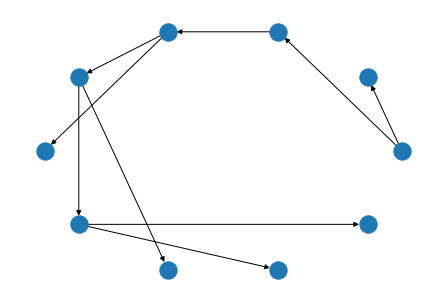

In [15]:
pos = nx.circular_layout(dag)
nx.draw(dag, pos)

In [16]:
def check_dag(dag, uuid_json_dict):
    json_loaded = set(uuid_json_dict.keys())
    dag_assigned = set(dag.nodes)
    missing = dag_assigned - json_loaded
    return missing

import networkx.algorithms.dag as nx_dag
existing_uuids = {}
ordered_nodes = list(reversed(list(nx_dag.topological_sort(dag))))
for node in ordered_nodes:
    existing_uuids[node] = from_json(all_json[node], existing_uuids)

In [17]:
existing_uuids

{65939417764579747063272163081445179410: <openpathsampling.engines.toy.integrators.LangevinBAOABIntegrator at 0x11e05cda0>,
 65939417764579747063272163081445179394: OuterWalls([1. 1.], [0. 0.]),
 65939417764579747063272163081445179396: Gaussian(-0.7000000000000001, [12. 12.], [0.  0.4]),
 65939417764579747063272163081445179398: <openpathsampling.engines.toy.pes.PES_Add at 0x11e05cdd8>,
 65939417764579747063272163081445179400: Gaussian(-0.7000000000000001, [12. 12.], [-0.5 -0.5]),
 65939417764579747063272163081445179402: <openpathsampling.engines.toy.pes.PES_Add at 0x11e05cf28>,
 65939417764579747063272163081445179404: Gaussian(-0.7000000000000001, [12. 12.], [ 0.5 -0.5]),
 65939417764579747063272163081445179406: <openpathsampling.engines.toy.pes.PES_Add at 0x11e05cd30>,
 65939417764579747063272163081445179408: <openpathsampling.engines.toy.topology.ToyTopology at 0x1200754a8>,
 65939417764579747063272163081445179414: <openpathsampling.engines.toy.engine.ToyEngine at 0x120075208>}